In [17]:
%matplotlib inline

In [18]:
# These are all the modules we'll be using later.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import scipy.io   
import h5py

import matplotlib.pyplot as plt

import os
import sys
import tarfile
from IPython.display import display, Image

from scipy import ndimage

import random

### Load and save SVHN to pickle

In [2]:
# load train/test dataset
train_data = scipy.io.loadmat('/Users/RyanG/anaconda/envs/tensorflow/bin/Udacity/SVHN/train_32x32.mat', variable_names='X').get('X')
train_labels = scipy.io.loadmat('/Users/RyanG/anaconda/envs/tensorflow/bin/Udacity/SVHN/train_32x32.mat', variable_names='y').get('y')
test_data = scipy.io.loadmat('/Users/RyanG/anaconda/envs/tensorflow/bin/Udacity/SVHN/test_32x32.mat', variable_names='X').get('X')
test_labels = scipy.io.loadmat('/Users/RyanG/anaconda/envs/tensorflow/bin/Udacity/SVHN/test_32x32.mat', variable_names='y').get('y')
extra_data = scipy.io.loadmat('/Users/RyanG/anaconda/envs/tensorflow/bin/Udacity/SVHN/extra_32x32.mat', variable_names='X').get('X')
extra_labels = scipy.io.loadmat('/Users/RyanG/anaconda/envs/tensorflow/bin/Udacity/SVHN/extra_32x32.mat', variable_names='y').get('y')

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(extra_data.shape, extra_labels.shape)

(32, 32, 3, 73257) (73257, 1)
(32, 32, 3, 26032) (26032, 1)
(32, 32, 3, 531131) (531131, 1)


In [45]:
train_dataset = train_data.transpose((3,0,1,2))
train_label = train_labels[:,0]
test_dataset = test_data.transpose((3,0,1,2))
test_label = test_labels[:,0]
extra_dataset = extra_data.transpose((3,0,1,2))
extra_label = extra_labels[:,0]


print(train_dataset.shape, train_label.shape)
print(test_dataset.shape, test_label.shape)
print(extra_dataset.shape, extra_label.shape)

(73257, 32, 32, 3) (73257,)
(26032, 32, 32, 3) (26032,)
(531131, 32, 32, 3) (531131,)


In [46]:
# create a validation dataset, 4/5 of data from train dataset , 1/5 from extra dataset
valid_size = 10000  
train_portion = int(valid_size * 0.8) 
extra_portion = int(valid_size * 0.2) 

In [47]:
valid_dataset = np.concatenate((train_dataset[:train_portion,:,:,:], extra_dataset[:extra_portion,:,:,:]))
valid_label = np.concatenate((train_label[:train_portion], extra_label[:extra_portion]))
train_dataset = train_dataset[train_portion:,:,:,:]
train_label = train_label[train_portion:]
                             
print(train_dataset.shape, train_label.shape)
print(test_dataset.shape, test_label.shape)
print(valid_dataset.shape, valid_label.shape)

(65257, 32, 32, 3) (65257,)
(26032, 32, 32, 3) (26032,)
(10000, 32, 32, 3) (10000,)


In [48]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_label = randomize(train_dataset, train_label)
test_dataset, test_label = randomize(test_dataset, test_label)
valid_dataset, valid_label = randomize(valid_dataset, valid_label)

In [34]:
def disp_sample_dataset(dataset, label):
    items = random.sample(range(dataset.shape[0]), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.title(label[i])
        plt.imshow(dataset[i])

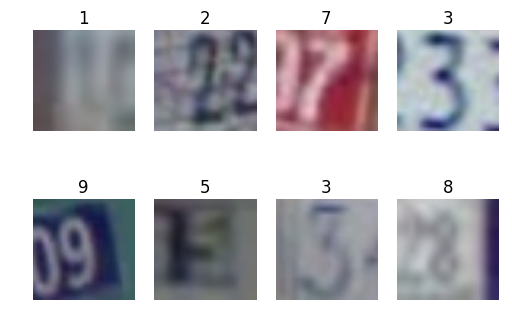

In [10]:
disp_sample_dataset(train_dataset, train_label)

In [88]:
pickle_file = 'SVHN_single_ori.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_label': train_label,
    'valid_dataset': valid_dataset,
    'valid_label': valid_label,
    'test_dataset': test_dataset,
    'test_label': test_label,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [89]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 311261505


In [7]:
pickle_file = 'SVHN_single_ori.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32, 3) (65257,)
Validation set (10000, 32, 32, 3) (10000,)
Test set (26032, 32, 32, 3) (26032,)


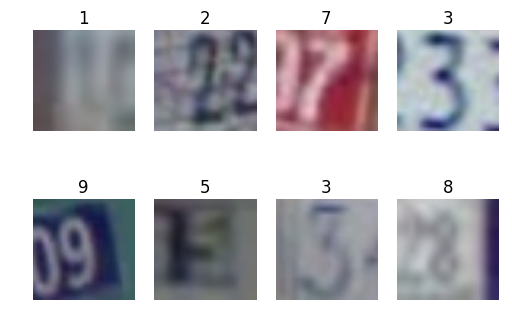

In [15]:
disp_sample_dataset(train_dataset, train_label)

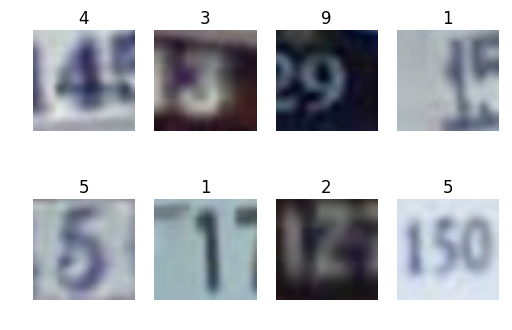

In [13]:
disp_sample_dataset(test_dataset, test_label)

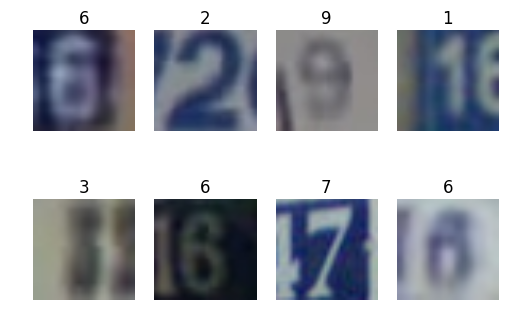

In [14]:
disp_sample_dataset(valid_dataset, valid_label)

In [11]:
image_size = 32  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    # Use the Conversion Method in This Paper:
    # [http://www.eyemaginary.com/Rendering/TurnColorsGray.pdf]
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(train_dataset)[:,:,:,0]
test_data_c = im2gray(test_dataset)[:,:,:,0]
valid_data_c = im2gray(valid_dataset)[:,:,:,0]

print(train_data_c.shape, train_label.shape)
print(test_data_c.shape, test_label.shape)
print(valid_data_c.shape, valid_label.shape)

(65257, 32, 32) (65257,)
(26032, 32, 32) (26032,)
(10000, 32, 32) (10000,)


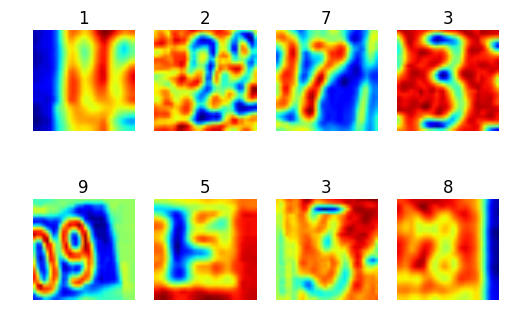

In [12]:
disp_sample_dataset(train_data_c, train_label)

In [24]:
pickle_file = 'SVHN_single_grey.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_data_c,
    'train_label': train_label,
    'valid_dataset': valid_data_c,
    'valid_label': valid_label,
    'test_dataset': test_data_c,
    'test_label': test_label,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [5]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""
    
    imsize = image.shape[0]
    mean = np.mean(image, axis=(1,2), dtype=float)
    std = np.std(image, axis=(1,2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)
    
    for i in np.arange(imsize):
        image_GCN[i,:,:] = (image[i,:,:] - mean[i]) / std[i]
        
    return image_GCN

train_data_GCN = GCN(train_dataset)
test_data_GCN = GCN(test_dataset)
valid_data_GCN = GCN(valid_dataset)

print(train_data_GCN.shape, train_label.shape)
print(test_data_GCN.shape, test_label.shape)
print(valid_data_GCN.shape, valid_label.shape)

(65257, 32, 32) (65257,)
(26032, 32, 32) (26032,)
(10000, 32, 32) (10000,)


In [37]:
pickle_file = 'SVHN_single_grey.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32) (65257,)
Validation set (10000, 32, 32) (10000,)
Test set (26032, 32, 32) (26032,)


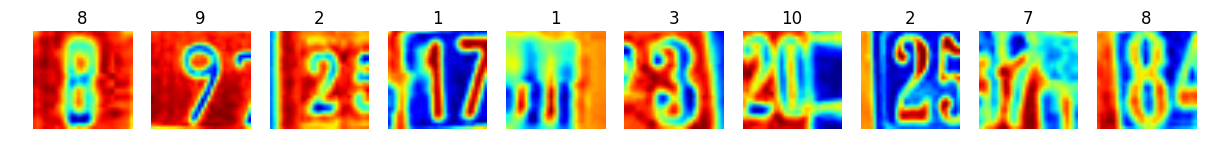

In [10]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_label.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_label[j], loc='center')
    ax[i].imshow(train_data_GCN[j,:,:])

In [14]:
pickle_file = 'SVHN_single_GCN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_data_GCN,
    'train_label': train_label,
    'valid_dataset': valid_data_GCN,
    'valid_label': valid_label,
    'test_dataset': test_data_GCN,
    'test_label': test_label,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [31]:
def global_contrast_normalize(X, scale=1., subtract_mean=True, use_std=False,
                              sqrt_bias=0., min_divisor=1e-4):
    """
    Global contrast normalizes by (optionally) subtracting the mean
    across features and then normalizes by either the vector norm
    or the standard deviation (across features, for each example).
    Parameters
    ----------
    X : ndarray, 2-dimensional
        Design matrix with examples indexed on the first axis and \
        features indexed on the second.
    scale : float, optional
        Multiply features by this const.
    subtract_mean : bool, optional
        Remove the mean across features/pixels before normalizing. \
        Defaults to `True`.
    use_std : bool, optional
        Normalize by the per-example standard deviation across features \
        instead of the vector norm. Defaults to `False`.
    sqrt_bias : float, optional
        Fudge factor added inside the square root. Defaults to 0.
    min_divisor : float, optional
        If the divisor for an example is less than this value, \
        do not apply it. Defaults to `1e-8`.
    Returns
    -------
    Xp : ndarray, 2-dimensional
        The contrast-normalized features.
    Notes
    -----
    `sqrt_bias` = 10 and `use_std = True` (and defaults for all other
    parameters) corresponds to the preprocessing used in [1].
    References
    ----------
    .. [1] A. Coates, H. Lee and A. Ng. "An Analysis of Single-Layer
       Networks in Unsupervised Feature Learning". AISTATS 14, 2011.
       http://www.stanford.edu/~acoates/papers/coatesleeng_aistats_2011.pdf
    """
    assert X.ndim == 2, "X.ndim must be 2"
    scale = float(scale)
    assert scale >= min_divisor

    # Note: this is per-example mean across pixels, not the
    # per-pixel mean across examples. So it is perfectly fine
    # to subtract this without worrying about whether the current
    # object is the train, valid, or test set.
    mean = X.mean(axis=1)
    if subtract_mean:
        X = X - mean[:, np.newaxis]  # Makes a copy.
    else:
        X = X.copy()

    if use_std:
        # ddof=1 simulates MATLAB's var() behaviour, which is what Adam
        # Coates' code does.
        ddof = 1

        # If we don't do this, X.var will return nan.
        if X.shape[1] == 1:
            ddof = 0

        normalizers = np.sqrt(sqrt_bias + X.var(axis=1, ddof=ddof)) / scale
    else:
        normalizers = np.sqrt(sqrt_bias + (X ** 2).sum(axis=1)) / scale

    # Don't normalize by anything too small.
    normalizers[normalizers < min_divisor] = 1.

    X /= normalizers[:, np.newaxis]  # Does not make a copy.
    return X

In [27]:
type(train_dataset[0])

numpy.ndarray

In [28]:
x = global_contrast_normalize(train_dataset[0])

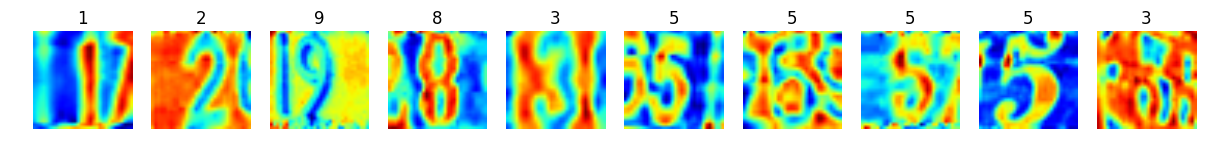

In [39]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_label.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_label[j], loc='center')
    ax[i].imshow(global_contrast_normalize(train_dataset[j], use_std = True))

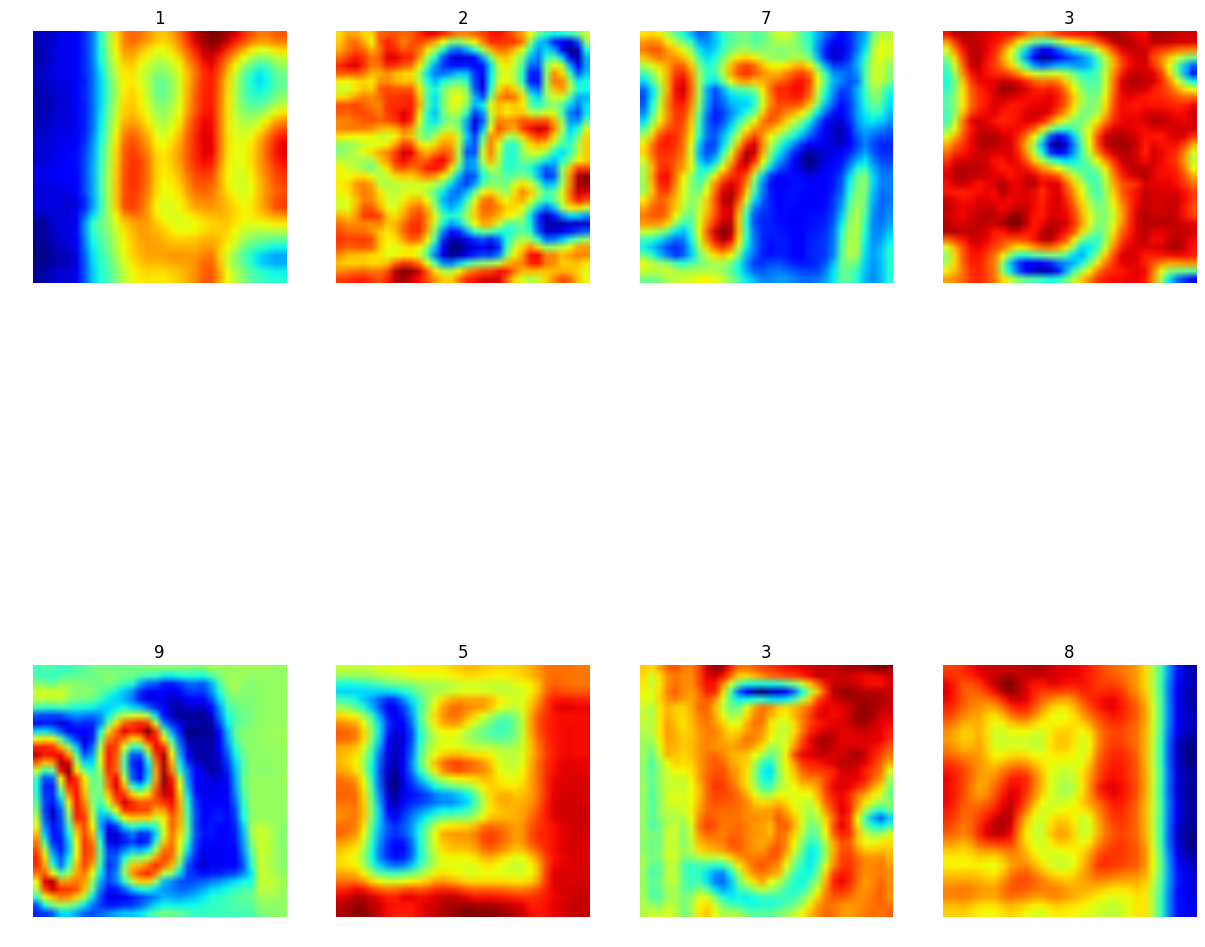

In [38]:
disp_sample_dataset(train_dataset, train_label)

In [40]:
pickle_file = 'SVHN_single_grey.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_label = save['train_label']
    valid_dataset = save['valid_dataset']
    valid_label = save['valid_label']
    test_dataset = save['test_dataset']
    test_label = save['test_label']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_label.shape)
    print('Validation set', valid_dataset.shape, valid_label.shape)
    print('Test set', test_dataset.shape, test_label.shape)

Training set (65257, 32, 32) (65257,)
Validation set (10000, 32, 32) (10000,)
Test set (26032, 32, 32) (26032,)


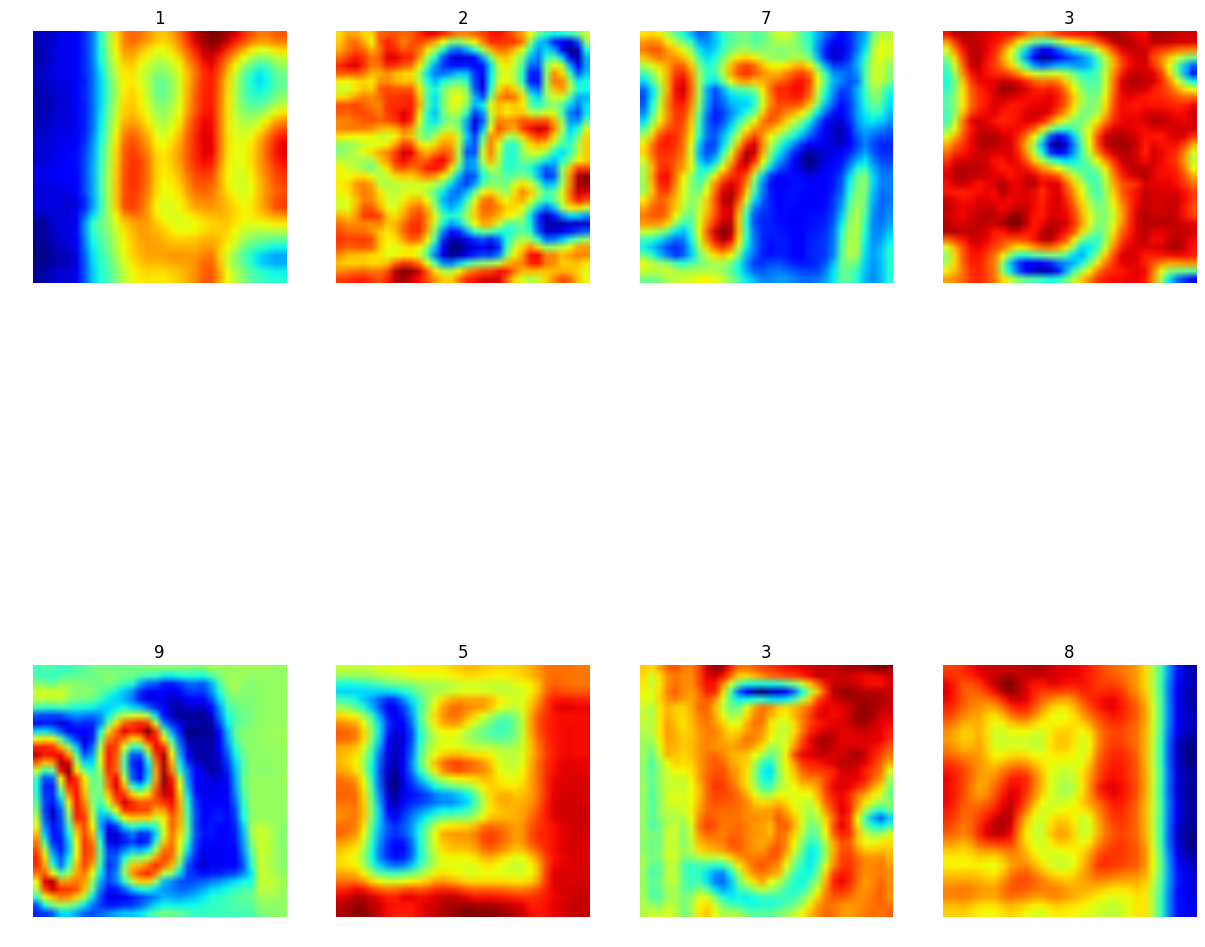

In [41]:
disp_sample_dataset(train_dataset, train_label)